In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nimfa
import NaiveDE
import pickle

/home/gapartel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/gapartel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


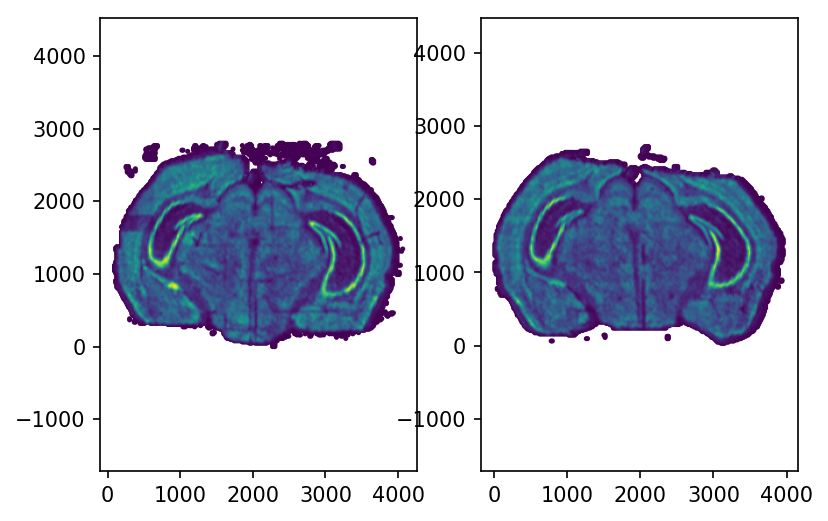

In [2]:
# load dataframes
datasets = ['170315_161220_4_1','161230_161220_3_1']
img_shape = np.round(np.array([[22508, 33566],[22563, 31782]])/8).astype(np.uint)
expression_df = []
sample_df = []
for i,dataset in enumerate(datasets):
    plt.rcParams["figure.dpi"] = 150
    plt.subplot(1,2,i+1)    
    
    x_min = 0; x_max= img_shape[i,1];
    y_min = 0; y_max= img_shape[i,0];
    batch_size_px=16
    overlap = 16
    express_table = pd.read_pickle('../data/results/'+dataset+'/express_table.hdf5')
    # Create sample_info
    sample_info = pd.DataFrame(data={'x':list(x for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px)), 'y':list(y for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px))}, index=list((str(x)+"x"+str(y)) for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px)))
    sample_info['total_counts'] = express_table.sum(axis=1)
    # Dropping empty batches
    express_table = express_table[sample_info.total_counts>10]
    sample_info = sample_info[sample_info.total_counts>10]
    
    expression_df.append(express_table)
    expression_df[i] = expression_df[i].rename(('{}_'+str(i)).format)

    sample_df.append(sample_info)
    sample_df[i] = sample_df[i].rename(('{}_'+str(i)).format)
    sample_df[i]['s'] = i
    plt.scatter(sample_df[i]['x'], sample_df[i]['y'], c=sample_df[i]['total_counts'],s=2);
    plt.axis('equal');

## Normalize Gene Expression Tables

In [3]:
expression_df=pd.concat(expression_df,sort=True)
expression_df=expression_df.dropna(axis=1)
#expression_df=expression_df.fillna(0)
sample_df=pd.concat(sample_df,sort=True)
                    
# Linear regression to account for library size and sequencing depth bias of each patch of gene expression
norm_expr = pd.concat([NaiveDE.stabilize(expression_df[sample_df.s==0].T).T,NaiveDE.stabilize(expression_df[sample_df.s==1].T).T])
resid_expr = pd.concat([NaiveDE.regress_out(sample_df[sample_df.s==0], norm_expr[sample_df.s==0].T, 'np.log(total_counts)').T,NaiveDE.regress_out(sample_df[sample_df.s==1], norm_expr[sample_df.s==1].T, 'np.log(total_counts)').T])
idx = resid_expr.var().sort_values(ascending=False).index

In [4]:
# Shift normalized values to positive range
resid_expr = resid_expr - resid_expr.min().min()
rank = 20

nmf = nimfa.Nmf(resid_expr.values, rank=rank, seed='random_vcol', max_iter=1000, 
                update='divergence', objective='div', n_run=3, track_factor=True)
nmf_fit = nmf()

In [5]:
# Save results
pickle.dump(nmf_fit, open( "../data/results/Nmf_res.hdf5", "wb" ) )

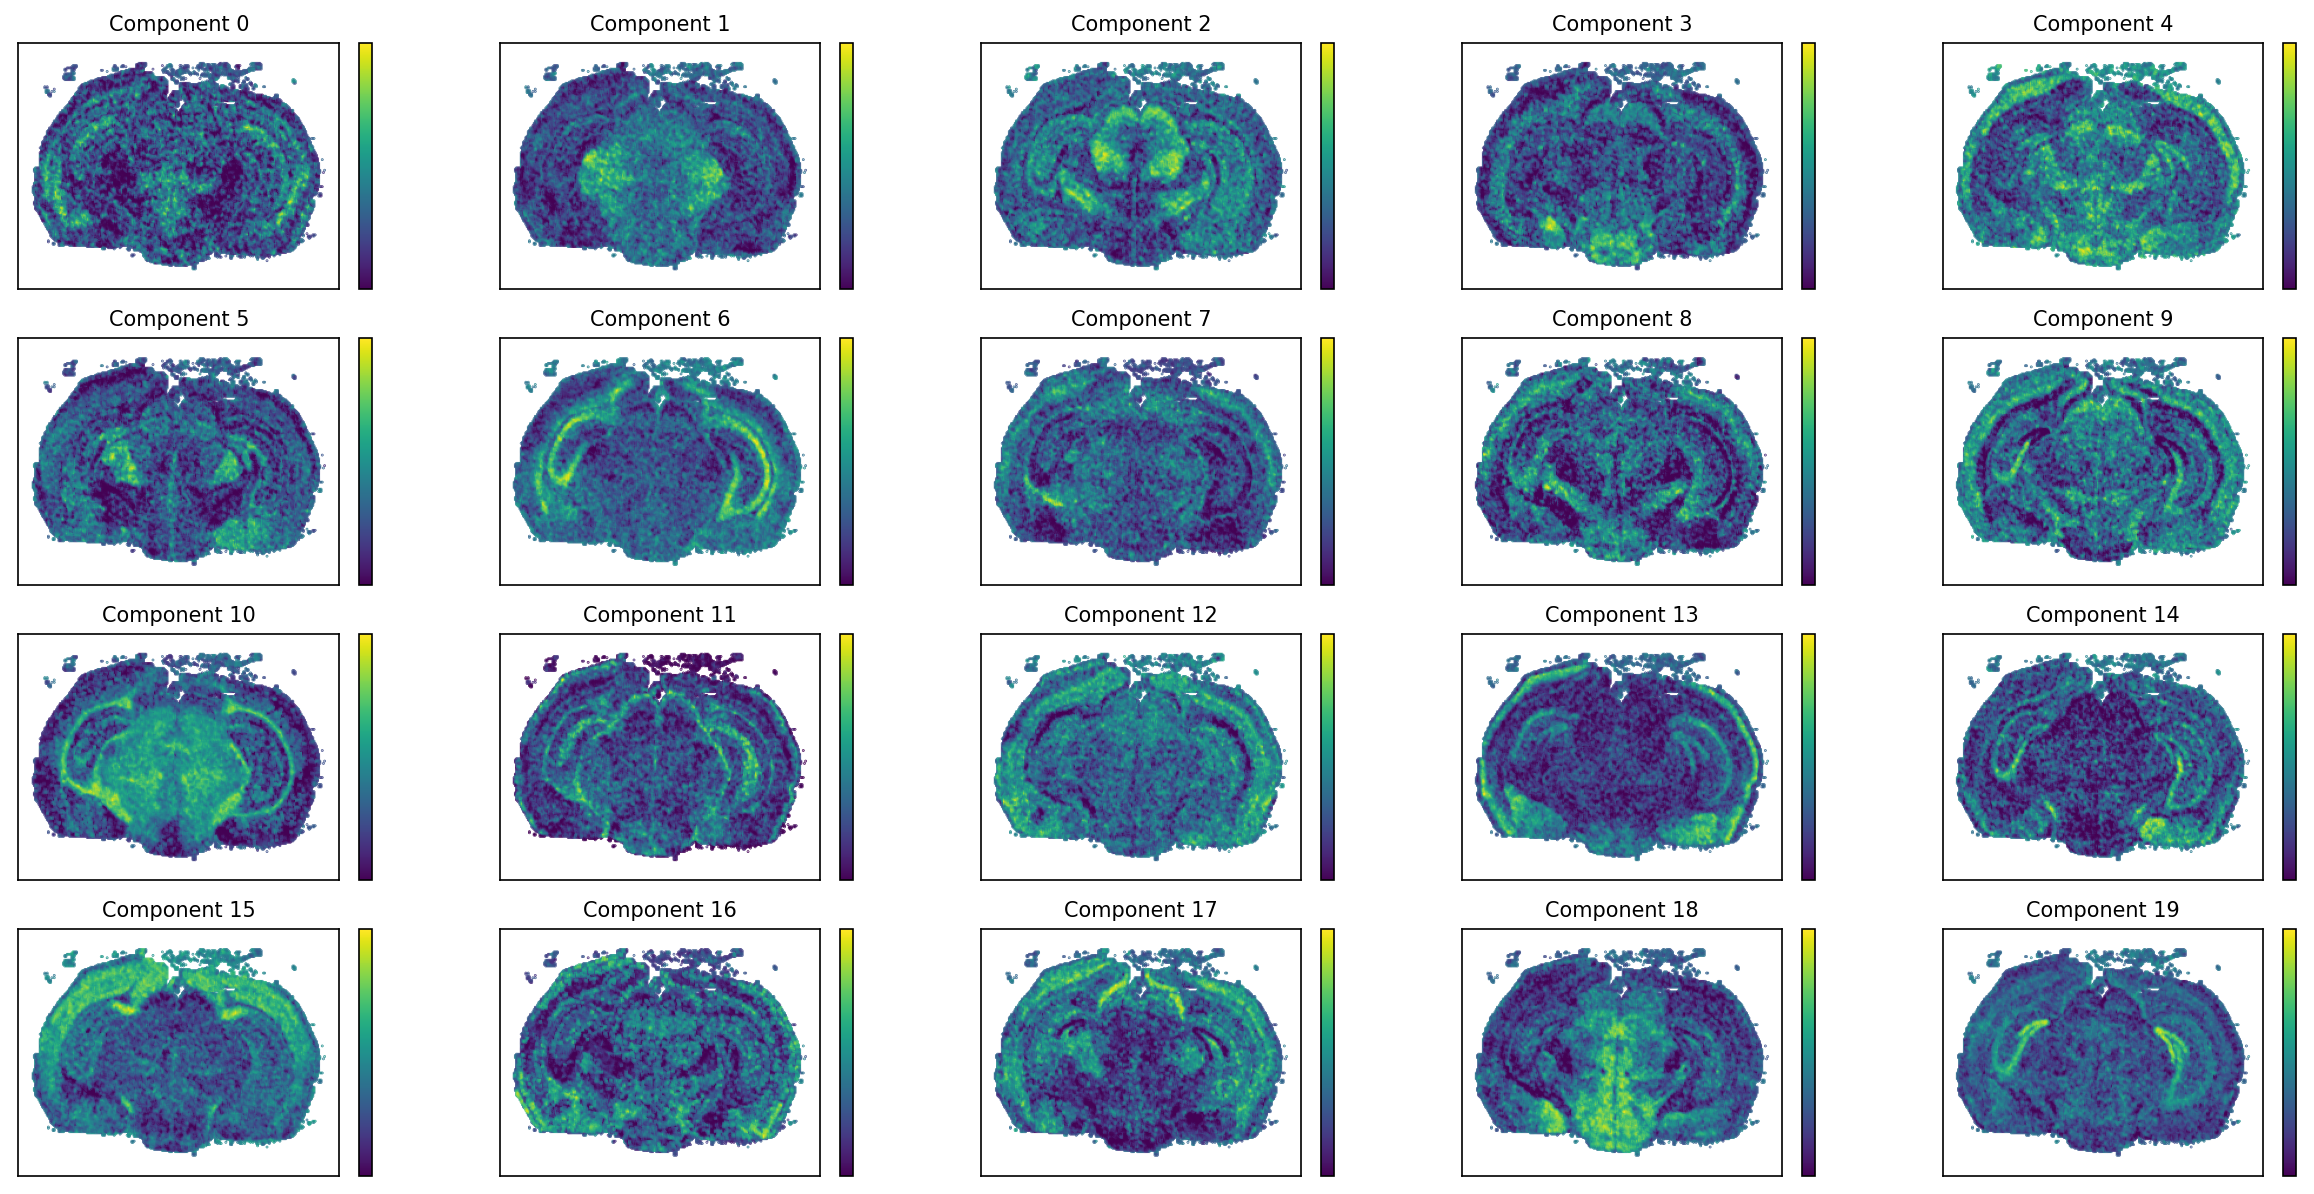

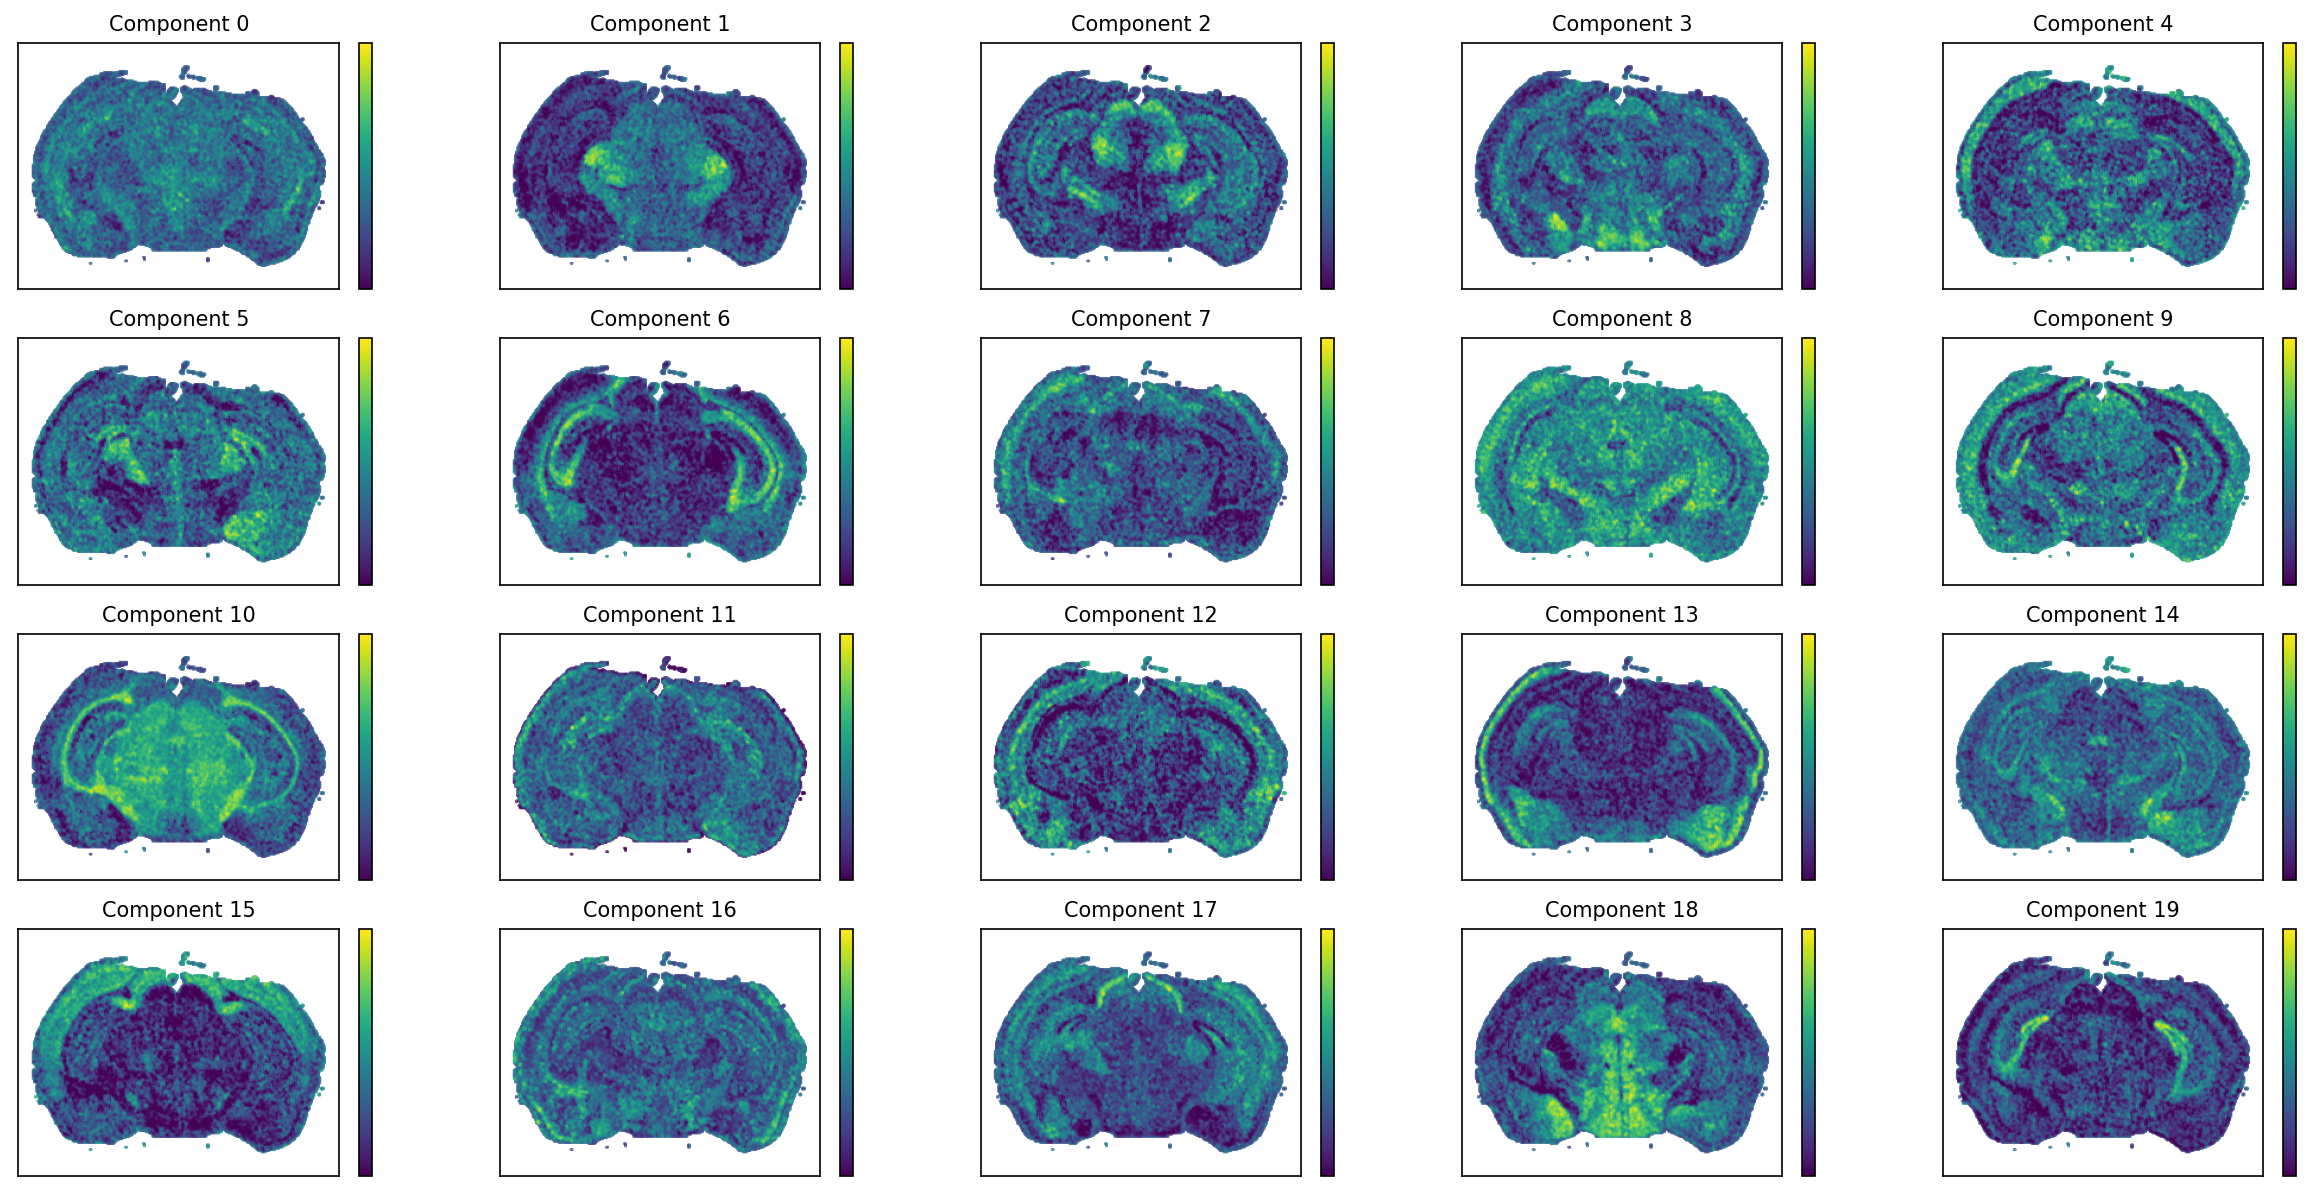

In [6]:
# Plot patterns (metagenes)
Y = np.array(nmf_fit.basis()).astype(np.float64)
for j,dataset in enumerate(datasets):
    for i in range(rank):
        sample_df.loc[sample_df.s==j,'Y'+str(i)] = Y[sample_df.s==j,i]
    plt.figure(figsize=(20,10))
    plt.title(dataset)
    for i in range(rank):
        plt.subplot(4, 5, i + 1)
        plt.scatter(sample_df.loc[sample_df.s==j,'x'], sample_df.loc[sample_df.s==j,'y'], c=sample_df.loc[sample_df.s==j,'Y'+str(i)], s=0.1);
        plt.title('Component {}'.format(i), fontsize=10)
        plt.axis('equal')
        plt.xticks([])
        plt.yticks([]);
        plt.colorbar(ticks=[]);

<Figure size 900x600 with 0 Axes>

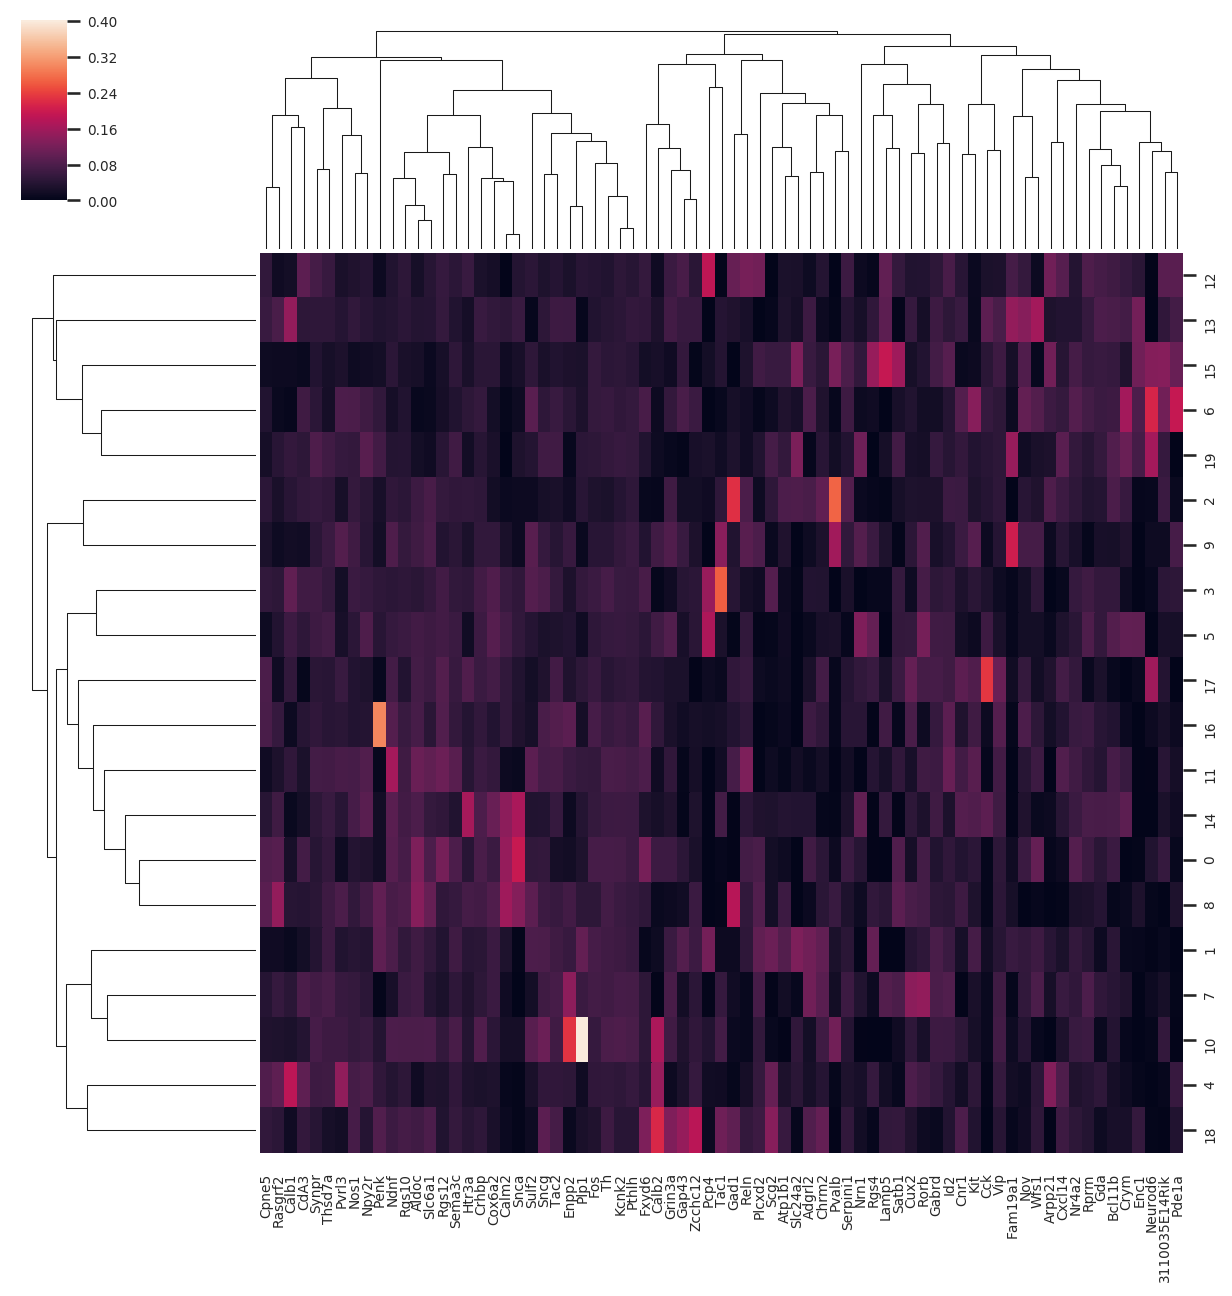

In [7]:
# Plot coefficient matrix
W = pd.DataFrame(np.array(nmf_fit.coef()).astype(np.float64), columns=resid_expr.columns) 
plt.figure()
sns.set(font_scale = 0.6)
g=sns.clustermap(W,xticklabels=True ,yticklabels=True, metric='correlation')